In [1]:
import segmentation_models_pytorch as smp
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b0",
    in_channels=3,
    encoder_depth=3, 
    decoder_channels=(64, 32, 16),
    classes=1,
    )

/home/ljb/miniconda3/envs/sde/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
from torch import nn
import torch
import math
import segmentation_models_pytorch as smp


class timeUnetPlusPlus(smp.UnetPlusPlus):
    def __init__(self, model_channels, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # self.timeEmb
        self.model_channels = model_channels
        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )
        self.lns = nn.ModuleList()
        self.lns.append(nn.Linear(time_embed_dim, 2))
        self.lns.append(nn.Linear(time_embed_dim, 32))
        self.lns.append(nn.Linear(time_embed_dim, 24))
        self.lns.append(nn.Linear(time_embed_dim, 40))
        
        self.name = 'timeUnetPlusPlus'
        self.initialize()

    def timestep_embedding(self, timesteps, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param timesteps: a 1-D Tensor of N indices, one per batch element.
                        These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an [N x dim] Tensor of positional embeddings.
        """
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=timesteps.device)
        args = timesteps[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding


    def forward(self, x, timesteps):        
        emb = self.time_embed(self.timestep_embedding(timesteps, self.model_channels))
        self.check_input_shape(x)
        features = self.encoder(x)
        for f in features:
            print(f.shape)
        print('===================')
        for index, f in enumerate(features):
            temp_emb = self.lns[index](emb)
            while len(temp_emb.shape) < len(f.shape):
                temp_emb = temp_emb[..., None]
            print(f.shape, temp_emb.shape)
            f = f + temp_emb
        decoder_output = self.decoder(*features)

        masks = self.segmentation_head(decoder_output)

        if self.classification_head is not None:
            labels = self.classification_head(features[-1])
            return masks, labels

        return masks
import os  
os.system('source ~/add_proxy.sh')

model = timeUnetPlusPlus(
    model_channels=64,
    encoder_name="efficientnet-b2",
    in_channels=2,
    encoder_depth=4, 
    decoder_channels=(64, 32, 16, 8),
    classes=1,
    )

成功添加代理


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /home/ljb/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


KeyboardInterrupt: 

In [22]:
x = torch.rand(100, 2, 32, 32)
t = torch.rand(100)
model(x, t).shape

torch.Size([100, 2, 32, 32])
torch.Size([100, 32, 16, 16])
torch.Size([100, 24, 8, 8])
torch.Size([100, 40, 4, 4])
torch.Size([100, 112, 2, 2])
torch.Size([100, 2, 32, 32]) torch.Size([100, 2, 1, 1])
torch.Size([100, 32, 16, 16]) torch.Size([100, 32, 1, 1])
torch.Size([100, 24, 8, 8]) torch.Size([100, 24, 1, 1])
torch.Size([100, 40, 4, 4]) torch.Size([100, 40, 1, 1])


IndexError: index 4 is out of range

In [42]:
from easydict import EasyDict as edict
import torch
import torchvision
from utils.Datasets import MNISTdataset
import pickle
from rich.progress import track
from utils.normalize import get_total_mean_std
from torch.utils.data import Dataset, DataLoader
from utils.data_utils import *
import numpy as np
def preprocess_mnist_data(args):
    if args.filter_number is not None:
        train_ds = torchvision.datasets.MNIST(
            root="./data/", 
            train=True, 
            download=True
            )
        imgs = []
        for img, label in train_ds:
            if label != args.filter_number:
                continue
            imgs.append(torch.Tensor(np.array(img)))
        length = int(len(imgs)/1000)*1000
        imgs = torch.stack(imgs[:length])
    
    # check data pickle file
    for i in track(range(60), description="Preprocessing dataset"):
        if (args.ds_cached_dir / f'new_ds_{i}.pkl').exists():
            continue
        ts, bridge, drift, source, target = gen_mnist_data((i*1000, (i+1)*1000), order=True, change_epsilons=args.change_epsilons)
        _, metadata = normalize_dataset(ts, bridge, drift, source, target)
        new_ds = MNISTdataset(ts, bridge, drift, source, target)
        new_ds.metadata = metadata
        pickle.dump(new_ds, open(args.ds_cached_dir / f'new_ds_{i}.pkl', 'wb'))
        
    get_total_mean_std(args)
    
    ret = {
        "nums_sub_ds": 60
    }
    
    return ret


args = edict(
    {
    'filter_number': 8
    }
)
preprocess_mnist_data(args)

torch.Size([5000, 28, 28])


In [43]:
from rich.scope import render_scope
def test(foo: float, bar: float) -> None:
    list_of_things = [1, 2, 3, None, 4, True, False, "Hello World"]
    dict_of_things = {
        "version": "1.1",
        "method": "confirmFruitPurchase",
        "params": [["apple", "orange", "mangoes", "pomelo"], 1.123],
        "id": "194521489",
    }
    print(render_scope(locals(), title="[i]locals", sort_keys=False))

test(20.3423, 3.1427)

In [19]:
import torch
from utils.bridge.models import UNetModel

kwargs = {'in_channels': 2, 
            'model_channels': 64, 
            'out_channels': 1, 
            'num_res_blocks': 4, 
            'attention_resolutions': (0,), 
            'dropout': 0.0, 
            'channel_mult': (1, 2, 4), 
            'num_classes': None, 
            'use_checkpoint': False, 
            'num_heads': 8, 
            'num_heads_upsample': -1, 
            'use_scale_shift_norm': True
            }

model = UNetModel(**kwargs)
before_train = None
after_train = None
print(f"{int(sum(p.numel() for p in model.parameters())/1e6)}M")

24M


In [13]:
x = torch.rand(100, 2, 28, 28)
t = torch.rand(100)
model(x, t).shape

torch.Size([100, 1, 28, 28])

In [21]:
import torchvision
train_ds = torchvision.datasets.MNIST(
    root="./data/", 
    train=True, 
    download=True
    )

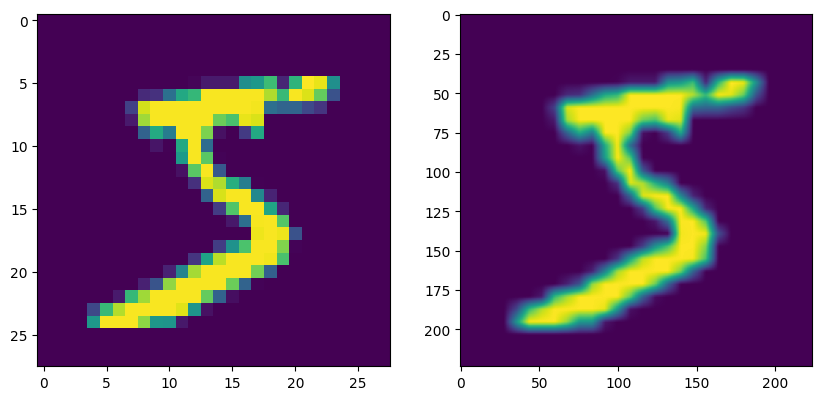

In [48]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
# 假设我们有一个 (28, 28) 的灰度图像
image = torch.Tensor(np.array(train_ds[0][0]))

# 调整形状以匹配 (N, C, H, W) 的格式
image = image.unsqueeze(0).unsqueeze(0)

# 使用双线性插值将图像大小更改为 (224, 224)
# 'nearest' | 'linear' | 'bilinear' | 'bicubic' | 'trilinear' | 'area' | 'nearest-exact'
resized_image1 = F.interpolate(image, size=(224, 224), mode='bilinear')
resized_image2 = F.interpolate(image, size=(224, 224), mode='bilinear')

# 最后的结果现在是 (1, 1, 224, 224)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image[0,0])
axs[1].imshow(resized_image1[0,0])
fig.show()

In [20]:
from models.unet import UNet
import torch
model = UNet(
    image_channels=2,
    ch_mults = (1, 2, 2),
    is_attn = (True, True, True),
    n_blocks = 1
)

In [21]:
x = torch.rand(7, 2, 32, 32)
t = torch.rand(7)
print(model(x, t).shape)

print(f"{int(sum(p.numel() for p in model.parameters())/1e6)}M")

torch.Size([7, 2, 32, 32])
9M


In [51]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import math
class timeUnetPlusPlus(smp.UnetPlusPlus):
    def __init__(self, model_channels, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # self.timeEmb
        self.model_channels = model_channels
        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )
        self.lns = nn.ModuleList()
        self.lns.append(nn.Linear(time_embed_dim, 2))
        # self.lns.append(nn.Linear(time_embed_dim, 32))
        # self.lns.append(nn.Linear(time_embed_dim, 24))
        # self.lns.append(nn.Linear(time_embed_dim, 40))
        self.lns.append(nn.Linear(time_embed_dim, 48))
        self.lns.append(nn.Linear(time_embed_dim, 32))
        self.lns.append(nn.Linear(time_embed_dim, 56))
        
        self.convs = nn.ModuleList()
        self.convs.append(nn.Conv2d(2 * 2, 2, 1))
        # self.convs.append(nn.Conv2d(32 * 2, 32, 1))
        # self.convs.append(nn.Conv2d(24 * 2, 24, 1))
        # self.convs.append(nn.Conv2d(40 * 2, 40, 1))
        self.convs.append(nn.Conv2d(48 * 2, 48, 1))
        self.convs.append(nn.Conv2d(32 * 2, 32, 1))
        self.convs.append(nn.Conv2d(56 * 2, 56, 1))
        
        self.name = 'timeUnetPlusPlus'
        self.initialize()

    def timestep_embedding(self, timesteps, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param timesteps: a 1-D Tensor of N indices, one per batch element.
                        These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an [N x dim] Tensor of positional embeddings.
        """
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=timesteps.device)
        args = timesteps[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, x, timesteps):        
        emb = self.timestep_embedding(timesteps, self.model_channels)
        emb = self.time_embed(emb)
        self.check_input_shape(x)
        features = self.encoder(x)
        
        for f in features:
            print(f.shape)
        
        for index, f in enumerate(features):
            temp_emb = self.lns[index](emb)
            while len(temp_emb.shape) < len(f.shape):
                temp_emb = temp_emb[..., None]
            # f = f + temp_emb
            f = torch.concat([f, temp_emb.repeat(1, 1, *f.shape[-2:])], dim=1)
            f = self.convs[index](f)
        decoder_output = self.decoder(*features)

        masks = self.segmentation_head(decoder_output)

        if self.classification_head is not None:
            labels = self.classification_head(features[-1])
            return masks, labels

        return masks

model = timeUnetPlusPlus(
    encoder_name="efficientnet-b4",
    model_channels=32,
    in_channels=2,
    encoder_depth=3, 
    decoder_channels=(64, 32, 16),
    classes=1,
    )
x = torch.rand(7, 2, 32, 32)
t = torch.rand(7)
model(x, t).shape

torch.Size([7, 2, 32, 32])
torch.Size([7, 48, 16, 16])
torch.Size([7, 32, 8, 8])
torch.Size([7, 56, 4, 4])


torch.Size([7, 1, 32, 32])